In [222]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as ks


from keras.models import Sequential
from keras.layers import Dense, Activation   
from keras.datasets import mnist, fashion_mnist
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM, Embedding
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,  classification_report
from sklearn.datasets import load_iris, load_digits, fetch_20newsgroups_vectorized, fetch_olivetti_faces

from imblearn.over_sampling import SMOTE

# MATH388E Lecture 11

## Newton-Raphson Method


The [Newton-Raphson algorithm](https://en.wikipedia.org/wiki/Newton%27s_method) is an iterative algorithm to find roots of a function. The main idea is to find successively better approximations to the roots. In order to find the roots, the algorithm starts with a random guess and then using the tangent line to the graph gets a better approximation. Then we repeat the procedure until we get a good-enough solution.

Consider the following simple problem: assume we have a real valued function $f(x)$ and we would like to solve the equation 

$$ f(x) = c $$

for some constant $c$.  Let us also assume that we made a guess $f(x_0) = c$.  Of course, unless we are extremely lucky, we are not going to hit the result. So, there will be an error:

$$ f(x_0) = c + \delta $$

Now, using this error, let us improve our guess:

$$ f(x_0) - \delta = c $$

But we want $\delta$ to effect $x_0$.  Assuming we have a *local inverse* we get

$$ f^{-1}(f(x_0) - \delta) = f^{-1}(c) = a $$

where $a$ is the solution we need to find.  Now, let us write the first order Taylor approximation for the left hand side:

$$ x_0 - (f^{-1})'(x_0) \cdot \delta \approx a $$

and we know that $(f^{-1})'(x_0) = \frac{1}{f'(x_0)}$

So, our next best guess is going to be

$$ x_1 = x_0 - \frac{\delta}{f'(x_0)} $$

If we convert this formula into an iterative approximation, we get

$$ x_{n+1} = x_n - \frac{\delta_n}{f'(x_n)} $$

where $\delta_n = f(x_n) - c$


In [3]:
def Solve(f, c, x0, eta=1e-2, n=10000):
    for i in range(n):
        delta = f(x0) - c
        der = (f(x0+eta/2) - f(x0-eta/2))/eta
        x1 = x0-delta/(der+eta*np.random.rand())
        if(abs(x0-x1)<eta):
            break
        else: 
            x0 = x1
    return([i,x1])

In [4]:
def fn(x):
    y = x*x
    return(1.0 + math.cos(y+0.2)+math.log(0.24+y))

In [5]:
x = Solve(fn,1.24,1.0,1e-10)
[x[0],x[1],fn(x[1])]

[8, 1.7734318154171977, 1.24]

## The gradient descent

Next, consider the following problem: we have a multivariable function $F(x_1,\ldots,x_n)$ that we want to optimize, i.e. find the point at which $F$ attains its minimum or maximum. There is an iterative algorithm called [steepest descent algorithm](https://ocw.mit.edu/courses/mathematics/18-409-topics-in-theoretical-computer-science-an-algorithmists-toolkit-fall-2009/lecture-notes/MIT18_409F09_scribe21.pdf) similar to Newton-Raphson that we can use to find this point. The algorithm uses the [gradient](https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/def_gradient.html) of the function. Recall that the gradient $\nabla F$ at a point $x$ 

$$ \nabla F = \left(\frac{\partial F}{\partial x_1},\ldots,\frac{\partial F}{\partial x_n}\right) $$

gives us the direction at which $F$ has the largest (in absolute value) derivative. The algorithm uses this information and iteratively pushes an initial guess into better and better approximations of the optimum point.

Let us start with an initial guess $a^{(0)}$ for $F(a_1^{(0)},\ldots,a_n^{(0)}) = c$, the update rule is going to be

$$ a^{(m+1)} = a^{(m)} - \eta \left(\nabla F\right)(a_1^{(m)},\ldots,a_n^{(m)}) $$

where $\eta$ is called *the learning rate*.

![](./images/steepest_descent.png)

(Image is taken from ["Learning-Based Auditory Encoding for Robust Speech Recognition" by Yu-Hsiang Bosco Chiu, Bhiksha Raj, and Richard M Stern](https://www.researchgate.net/figure/An-example-of-steepest-descent-optimization-steps_fig2_220655581)

In [2]:
def grad(f,x,eta=1e-4):
    def delta(i,j): 
        if(i==j): return(1) 
        else: return(0)
    def der(i,eta=1e-4):
        vec = np.array([delta(i,j) for j in range(len(x))])
        x1 = x + vec*eta/2
        x0 = x - vec*eta/2
        return((f(x1) - f(x0) + eta*np.random.rand())/eta)
    return(np.array([der(i,eta) for i in range(len(x))]))

In [3]:
def MSolve(f,c,x0,eta=1e-4,n=1000):
    for i in range(n):
        delta = f(x0) - c
        x1 = x0 - delta*eta*grad(f,x0,eta)
        err = np.linalg.norm(x1-x0)
        if(err < eta):
            break
        else:
            x0 = x1
    return([i,x1])

In [4]:
def g(x):
    y = x[0]*x[0]+x[1]*x[1]
    return(1.0+math.atan(y)+math.log(1.0+y))

MSolve(g,3.0,[0.0,0.0])

[8, array([0.00109836, 0.00101397])]

## The perceptron


Perceptrons are the main building blocks of artificial neural networks. They are designed to solve binary classification problems. They take a collection of input values $x = (x_1,\ldots,x_n)$ apply a linear combination 

$$\alpha\cdot x + \beta = a_1 x_1 + \cdots + a_n x_n + \beta$$ 

using a collection of weights $\alpha = (a_0,\ldots,a_n)$ and $\beta$ to be determined via an iterative approach. Then we apply an activation function $\varphi(x)$ to get an output which is either 0 or 1.

![Perceptron](./images/perceptron.gif)

([Source: Multilayer perceptrons from "Nonlinear Switching State-Space Models" by Antti Honkela](https://users.ics.aalto.fi/ahonkela/dippa/node41.html))


This is a generalization of the [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) algorithm we covered in [Lecture 6](./lecture-06.ipynb) and [Lecture 7](./lecture-07.ipynb).  In the logistic regression case $\varphi(x) = \frac{1}{1+e^{-x}}$.  So, if we have a collection of data points $(x^{(i)},y^{(i)})$ that we assume satisfy a relationship of the form

$$ y^{(i)} - \varphi(\alpha\cdot x^{(i)} + \beta) \sim N(0,\sigma) $$

where $\varphi\colon\mathbb{R}\to\mathbb{R}$ is a real valued function of a single variable, $\alpha$ and $x^{(i)}$ are vectors in an inner product space and $\beta$ is a scalar.  Our task is to find the best fitting pair $(\alpha,\beta)$ such that 

$$ \sum_i (y^{(i)} - \varphi(\alpha\cdot x^{(i)} + \beta))^2 $$

is minimized. So, we proceed by an iterative update:

$$ \alpha^{(n+1)} = \alpha^{(n)} - \frac{\eta \delta^{(n)}}{\varphi'(\alpha^{(n)}\cdot x^{(n)}+\beta^{(n)})} x^{(n)} $$

where $\delta^{(n)} = \varphi(\alpha^{(n)}\cdot x^{(n)} + \beta^{(n)}) - y^{(n)}$

### Feed-forward and back-probagation

In the feed-forward stage of the computation we calculate the output $\varphi(\alpha^{(n)}\cdot x + \beta^{(n)})$. In the back-probagation phase, we calculate the error $y - \varphi(\alpha^{(n)}\cdot x + \beta^{(n)})$ and adjust the weights as described above to obtain the next iteration of weights $(\alpha^{(n+1)},\beta^{(n+1)})$.

### An example

For this example, we are going to use a [toy dataset](http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)) from UCI: 

In [56]:
sonar = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
                    sep=",",
                    header=None)
sonar.head(10)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,R
7,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,...,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,R
8,0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,...,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,R
9,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,R


In [57]:
xs = sonar.iloc[:,0:60]
ys = sonar.iloc[:,60].replace({'R': 0, 'M': 1})

In [58]:
def diff(f,x,eta):
    return((f(x+eta/2)-f(x-eta/2))/eta)

def sigmoid(x): return(1.0/(1.0+math.exp(-x)))

In [66]:
def train(xs, ys, f, epochs, batches, eta, tol):
    n = len(xs.iloc[0,:])
    num = len(xs)
    w = np.random.rand(n+1)
    err = []
    temp = 0.0
    for i in range(epochs):
        j = np.random.randint(num)
        x = xs.iloc[j,:]
        y = ys[j]
        x0 = np.append([1],x)
        x1 = np.dot(w,x0)
        delta = f(x1) - y
        if(i%batches == batches-1):
            err.append(temp)
            temp = 0.0
        elif(abs(delta) > tol):
            temp = temp + 1.0/batches
        der = diff(f,x1,eta)+eta*np.random.rand()
        w = w - (der*delta*eta)*x0
    return(ys,err)

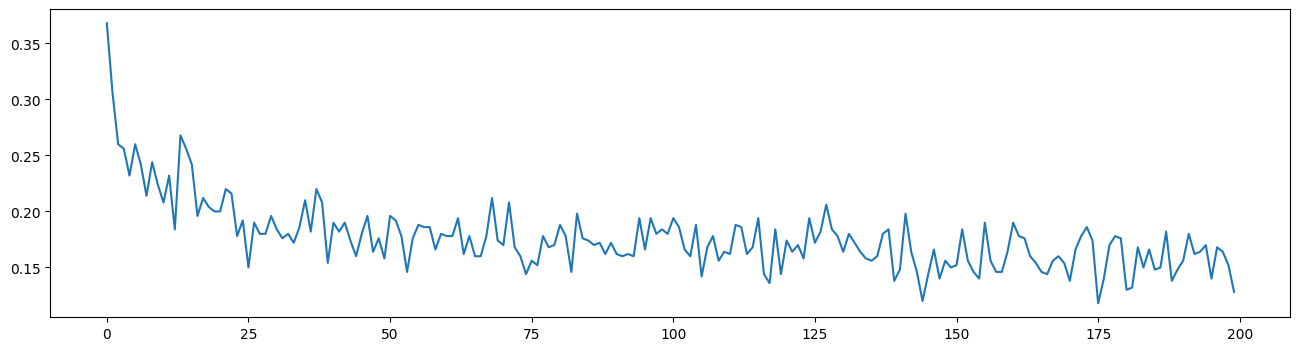

In [70]:
y_predict,errors = train(xs,ys,sigmoid,int(1e5),500,5e-1,0.45)
plt.figure(figsize=(16,4))
plt.plot(errors)

In [71]:
def helper(x,th=0.5):
    if x>=th:
        return 1
    else:
        return 0
    
tmp = np.vectorize(helper)(y_predict)
confusion_matrix(ys,tmp)

array([[ 97,   0],
       [  0, 111]])

## Neural networks

While perceptrons are limited in their ability to learn complex non-linear relationships, they can be combined into more sophisticated architectures called [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network). Another way of saying would be a neural network is a directed computation graph of perceptrons:

![](./images/neural-net.png)

(Source: [Wikipedia](https://en.wikipedia.org/wiki/Artificial_neural_network))

Neural networks are composed of multiple layers of interconnected perceptrons. Thus their weights form a sequence of matrices (a tensor) $(w^i_{j,k})$.  In the feedforward phase of the network,  where the input $(x^i_j)$ at some layer $i$ is processed by the network as

$$ x^{i+1}_k = \sum_j f^i_k(x^i_j w^i_{j,k}) $$

where $f^i_k$ is the activation function at the neuron $k$ at level $i$. Again, as in the case of perceptron, when we get the output from the output layer, we calculate the error and then propagate the error back updating weights iteratively. This procedure is a variation of gradient descent algorithm we outlined above.

There is a [very large number](http://www.asimovinstitute.org/neural-network-zoo/) of different types of neural networks. Unlike the perceptrons, it is neither practical nor recommended that you implement neural networks by hand. 

![](images/meme.jpg)

 I would suggest Use one of the following libraries or frameworks: 

1. [TensorFlow](https://www.tensorflow.org/)
2. [Keras](https://keras.io/)
3. [scikit-learn Neural Network](https://github.com/aigamedev/scikit-neuralnetwork)
4. [The Microsoft Cognitive Toolkit](https://learn.microsoft.com/en-us/cognitive-toolkit/)
5. [Theano](https://github.com/Theano/Theano)
6. [MXNet](https://mxnet.apache.org/versions/1.9.1/)

Tensorflow has a very nice [playground](https://playground.tensorflow.org/) where you can experiment with different architectures, activations functions etc. I highly recommend it.

## An example 

All of todays examples are going to use the keras library. Let us start with the first example we used today, the sonar dataset. Let us construct a simple neural-net for binary classification, i.e. a perceptron:

In [250]:
model = Sequential()

model.add(Dense(1, activation='sigmoid', input_dim=60))
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [251]:
X_train, X_test, y_train, y_test = train_test_split(xs,ys,train_size=0.7)

model.fit(X_train, y_train, epochs=1000, batch_size=75)

Epoch 1/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.6779 - binary_accuracy: 0.5517
Epoch 2/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.6700 - binary_accuracy: 0.5517
Epoch 3/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.6658 - binary_accuracy: 0.6000
Epoch 4/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.6626 - binary_accuracy: 0.6207
Epoch 5/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.6603 - binary_accuracy: 0.6621
Epoch 6/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.6582 - binary_accuracy: 0.6690
Epoch 7/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.6572 - binary_accuracy: 0.6828
Epoch 8/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.6550 - binary_accuracy: 0.6828
Epoch 9/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.6538 - binary_accuracy: 0.6897
Epoch 10/1000
2/2 [==============================] - 0s

In [254]:
y_predict = model.predict(X_test)
tmp = np.vectorize(lambda x: helper(x,th=0.75))(y_predict.reshape(y_predict.shape[0]))
confusion_matrix(y_test,tmp)

2/2 [==============================] - 0s 1ms/step


array([[26,  3],
       [16, 18]])

## Another standard small example



In [256]:
iris = load_iris()
x_iris = iris['data']
y_iris = iris['target']

labeler = LabelBinarizer()
y = labeler.fit_transform(y_iris)

x_train, x_test, y_train, y_test = train_test_split(x_iris, y)

In [257]:
model = Sequential()

model.add(Dense(32, activation='relu', input_dim=4))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu', input_dim=4))
model.add(Dense(3,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model.fit(x_train,y_train,epochs=500,batch_size=200)

Epoch 1/500
1/1 [==============================] - 0s 466ms/step - loss: 0.6780 - binary_accuracy: 0.5000
Epoch 2/500
1/1 [==============================] - 0s 3ms/step - loss: 0.6543 - binary_accuracy: 0.5595
Epoch 3/500
1/1 [==============================] - 0s 4ms/step - loss: 0.6390 - binary_accuracy: 0.5595
Epoch 4/500
1/1 [==============================] - 0s 4ms/step - loss: 0.6271 - binary_accuracy: 0.5565
Epoch 5/500
1/1 [==============================] - 0s 4ms/step - loss: 0.6175 - binary_accuracy: 0.6220
Epoch 6/500
1/1 [==============================] - 0s 4ms/step - loss: 0.6100 - binary_accuracy: 0.6667
Epoch 7/500
1/1 [==============================] - 0s 3ms/step - loss: 0.6061 - binary_accuracy: 0.6667
Epoch 8/500
1/1 [==============================] - 0s 4ms/step - loss: 0.6018 - binary_accuracy: 0.6667
Epoch 9/500
1/1 [==============================] - 0s 4ms/step - loss: 0.5964 - binary_accuracy: 0.6667
Epoch 10/500
1/1 [==============================] - 0s 3ms/ste

In [258]:
y_pred = model.predict(x_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

print(accuracy_score(yy_test,yy_pred))
confusion_matrix(yy_test,yy_pred)

2/2 [==============================] - 0s 2ms/step
0.9210526315789473


array([[12,  0,  0],
       [ 0, 14,  0],
       [ 0,  3,  9]])

In [259]:
y_pred

array([[6.6020966e-06, 9.9992770e-01, 5.3148720e-05],
       [6.6270149e-09, 2.2084201e-02, 9.8279935e-01],
       [7.4934636e-10, 3.7157659e-03, 9.9757677e-01],
       [9.9958754e-01, 8.2937069e-04, 9.7464650e-08],
       [7.9521256e-10, 1.2047476e-01, 9.1299713e-01],
       [5.1793204e-06, 9.9968290e-01, 2.5715888e-04],
       [3.6454610e-05, 9.9945444e-01, 8.5482607e-05],
       [9.9965632e-01, 7.3935132e-04, 4.8321169e-08],
       [4.6326207e-07, 9.9231827e-01, 8.3136428e-03],
       [1.9117485e-04, 9.9978745e-01, 2.9552557e-05],
       [9.9947906e-01, 2.0156903e-03, 2.8009495e-08],
       [2.2993781e-07, 8.5837466e-01, 2.0617901e-01],
       [9.9976617e-01, 4.1592849e-04, 3.1477271e-08],
       [1.4878245e-04, 9.9923879e-01, 2.1009252e-04],
       [1.6411866e-13, 4.7180527e-07, 9.9999982e-01],
       [1.7360902e-04, 9.9953347e-01, 4.6914833e-05],
       [3.1132036e-05, 9.9983960e-01, 4.8790087e-05],
       [5.6844405e-05, 9.9980879e-01, 5.9852300e-05],
       [3.6033746e-04, 9.990

## A Large Example



In [267]:
digits = load_digits()
x_digits = digits['data']
y_digits = digits['target']

labeler = LabelBinarizer()

yy_digits = labeler.fit_transform(y_digits)
xx_digits = x_digits.reshape(1797,8,8,1)

x_train, x_test, y_train, y_test = train_test_split(xx_digits, yy_digits)

model = Sequential()

model.add(Conv2D(32, (3, 2), padding="same", activation='relu', input_shape=(8,8,1)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [272]:
model.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0034 - binary_accuracy: 0.9999
Epoch 2/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0030 - binary_accuracy: 0.9999
Epoch 3/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0029 - binary_accuracy: 0.9999
Epoch 4/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0026 - binary_accuracy: 0.9999
Epoch 5/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0023 - binary_accuracy: 0.9999
Epoch 6/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0022 - binary_accuracy: 0.9999
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0021 - binary_accuracy: 0.9999
Epoch 8/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0027 - binary_accuracy: 0.9999
Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0021 - binary_accuracy: 0.9999
Epoch 10/10
22/22 [==============================] - 0s

In [273]:
y_pred = model.predict(x_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

print(accuracy_score(yy_test,yy_pred))
confusion_matrix(yy_test,yy_pred)

15/15 [==============================] - 0s 878us/step
0.9866666666666667


array([[43,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 35,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 51,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 46,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 40,  0,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  0, 50,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 46,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 46,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 50,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 37]])

## Yet Another Example


In [274]:
faces = fetch_olivetti_faces(data_home='/home/kaygun/local/data/scikit_learn_data/')
binarizer = LabelBinarizer()

y = binarizer.fit_transform(faces.target.flatten()).reshape(-1,40)
X = faces.data.flatten().reshape(-1,4096)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75)

In [281]:
model = Sequential()

model.add(Dense(128, activation="relu",input_shape=(4096,)))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(40, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy')

model.fit(X_train, y_train, batch_size=64, epochs=1000, validation_data=(X_test,y_test))

Epoch 1/1000
5/5 [==============================] - 1s 34ms/step - loss: 3.7890 - val_loss: 3.7932
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.7241 - val_loss: 3.8330
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.6978 - val_loss: 3.7112
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.6716 - val_loss: 3.7299
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.6609 - val_loss: 3.6748
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 3.6627 - val_loss: 3.6749
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 3.6433 - val_loss: 3.6804
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.6359 - val_loss: 3.6690
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.6206 - val_loss: 3.6894
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.6018 - val_loss: 3.6585
Epoch 11/

In [282]:
y_pred = model.predict(X_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

print(accuracy_score(yy_test,yy_pred))

4/4 [==============================] - 0s 2ms/step
0.87


In [283]:
print(classification_report(yy_test,yy_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       0.67      1.00      0.80         2
           4       0.67      1.00      0.80         4
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         1
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       0.75      1.00      0.86         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         4
          15       0.75      1.00      0.86         3
          16       1.00      1.00      1.00         1
          17       0.50    

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
